In [1]:
import numpy as np
import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.mixture import GaussianMixture

In [2]:
plt.rcParams.update({
    "font.size": 1,
    "axes.labelsize": 12,
    "axes.titlesize": 13,
    "legend.fontsize": 10,
})

def _setup_legend(ax, n_columns=5):
    """统一的图例设置辅助函数"""
    ax.legend(
        title='Class',
        loc='upper center',             # 图例的锚点：上边缘居中
        bbox_to_anchor=(0.5, -0.2),     # 放置位置：X轴中心(0.5)，Y轴下方(-0.2)
        ncol=n_columns,                 # 分5列
        borderaxespad=0.,
        frameon=False,
        columnspacing=1.0,              # 列间距
        handletextpad=0.5               # 图标与文字间距
    )

In [3]:
def visualization(
    X, y,
    projector_name="",
    model=None,  # 接收任意 fit 好的聚类模型
    save_name=None,
    figsize=(8, 6),
):
    unique_labels = np.unique(y)
    cmap = plt.get_cmap("tab10", len(unique_labels))
    markers = ['o', '^', 's', 'D', 'P', 'X', '*', 'v', '<', '>']

    fig, ax = plt.subplots(figsize=figsize, dpi=300)

    # --- 1. 通用决策边界绘制 (Meshgrid + Predict) ---
    if model is not None:
        # 获取模型名称用于标题
        model_name = str(model.__class__).split('.')[-1].replace("'>", "").replace("class ", "")
        
        # 创建网格
        x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
        y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
        xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                             np.linspace(y_min, y_max, 200))

        # 预测网格中每个点的 Cluster ID
        # 这种方法对 KMeans, GMM, SVM 等所有支持 predict 的模型都通用
        Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
        Z = Z.reshape(xx.shape)

        # 绘制背景分区 (透明度高)
        ax.contourf(xx, yy, Z, alpha=0.15, cmap='Pastel1')
        # 绘制分界线
        ax.contour(xx, yy, Z, levels=np.arange(Z.max() + 1) - 0.5, 
                   linewidths=1.5, colors='red', linestyles='--')

        # --- 2. 绘制质心 (自动适配 KMeans 和 GMM) ---
        centers = None
        if hasattr(model, 'cluster_centers_'): # KMeans
            centers = model.cluster_centers_
        elif hasattr(model, 'means_'): # GMM
            centers = model.means_
            
        if centers is not None:
            ax.scatter(centers[:, 0], centers[:, 1], s=50, c='black', marker='x', 
                       linewidths=2, zorder=10, label=f'{model_name} Centers')
            
        ax.set_title(f'{projector_name} Space with {model_name} Boundaries')
    else:
        ax.set_title(f'{projector_name} Space')

    # --- 3. 绘制真实数据散点 ---
    for idx, label in enumerate(unique_labels):
        mask = (y == label)
        ax.scatter(
            X[mask, 0], X[mask, 1],
            s=20, alpha=0.8, color=cmap(idx),
            marker=markers[idx % len(markers)],
            edgecolors='white', linewidth=0.5,
            label=str(label)
        )

    ax.set_xlabel(f'{projector_name} 1')
    ax.set_ylabel(f'{projector_name} 2')
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)
    
    # 图例
    _setup_legend(ax, n_columns=min(5, len(unique_labels)))

    if save_name:
        fig.savefig(save_name, bbox_inches='tight')

    return fig, ax


In [4]:
def clustering(projector, model, X, y):
    """
    projector: 降维模型实例 (e.g. PCA(n_components=2))
    model:     聚类模型实例 (e.g. KMeans(n_clusters=2) 或 GaussianMixture(...))
    X, y:      数据与标签
    """
    # 1. 准备名字
    projector_name = str(projector.__class__).split('.')[-1].replace("'>", "").replace("class ", "")
    model_name = str(model.__class__).split('.')[-1].replace("'>", "").replace("class ", "")
    
    print(f"Running Projector: {projector_name}...")
    _2d_data = projector.fit_transform(X)
    
    print(f"Running Clustering: {model_name}...")
    model.fit(_2d_data)
    
    # 获取聚类结果
    cluster_labels = model.predict(_2d_data)
    
    print("Visualizing...")
    fig, ax = visualization(
        _2d_data, y, 
        projector_name=projector_name, 
        model=model
    )
    plt.show()
    
    return _2d_data, cluster_labels

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC, SVC
class ClassifierFromCluster:
    """
    一个混合模型：
    1. 先用 base_clusterer (如 GMM) 找到聚类大概在哪。
    2. 再用 Polynomial Logistic Regression 拟合出一个平滑的决策边界（红线）。
    """
    def __init__(self, base_clusterer, classifer):
        self.base_clusterer = base_clusterer
        self.classifier = classifer
        
    def fit(self, X, y=None):
        self.base_clusterer.fit(X)
        pseudo_labels = self.base_clusterer.predict(X)
        self.classifier.fit(X, pseudo_labels)
        return self

    def predict(self, X):
        return self.classifier.predict(X)
    @property
    def means_(self):
        if hasattr(self.base_clusterer, 'means_'):
            return self.base_clusterer.means_
        if hasattr(self.base_clusterer, 'cluster_centers_'):
            return self.base_clusterer.cluster_centers_
        return None

In [6]:
# data_length = len(X_normal)
# effective_perplexity = min(30, max(5, (data_length - 1) // 3))
# projector = TSNE(
#     n_components=2,
#     random_state=42,
#     max_iter=1000,
#     perplexity=effective_perplexity,
#     init='pca',
#     learning_rate='auto',
# )
# cluster = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
# classifier = ClassifierFromCluster(base_clusterer=cluster, classifer=LogisticRegression(max_iter=1000))
# _ = clustering(
#     projector,
#     cla, 
#     X_normal, 
#     y_normal
# )

In [7]:
from ae_ideal.DataPreprocessor import DataPreprocessor
import torch
import os
import subprocess
from pathlib import Path
import torchaudio

In [8]:
def get_git_branch():
    """通过 subprocess 获取当前 git 分支名称"""
    try:
        branch = subprocess.check_output(
            ["git", "rev-parse", "--abbrev-ref", "HEAD"]
        ).decode("utf-8").strip()
        return branch
    except Exception as e:
        print(f"Warning: Could not detect git branch ({e}). Using 'unknown'.")
        return "unknown"
autoencoder_type = "normal" if get_git_branch() == "master" else "noise"

In [9]:
to_latent = DataPreprocessor().to_latent
esc_audio_dir = Path("data/ESC-50-master/audio")
device = "cuda" if torch.cuda.is_available() else "mps" if torch.mps.is_available() else "cpu"


In [10]:
if autoencoder_type == "normal":
    X = np.load("visualize/master_all_X.npy")
    y = np.load("visualize/master_all_y.npy")
elif autoencoder_type == "noise":
    X = np.load("visualize/disturbed_latent_all_X.npy")
    y = np.load("visualize/disturbed_latent_all_y.npy")
else:
    raise     

In [11]:
data_length = len(X)
effective_perplexity = min(30, max(5, (data_length - 1) // 3))
# projector = TSNE(
#     n_components=2,
#     random_state=42,
#     max_iter=1000,
#     perplexity=effective_perplexity,
#     init='pca',
#     learning_rate='auto',
# )
projector = PCA(n_components=2)
cluster = GaussianMixture(n_components=2, covariance_type='full', random_state=42)
classifier = ClassifierFromCluster(base_clusterer=cluster, classifer=LogisticRegression(max_iter=1000))

Running Projector: PCA...
Running Clustering: ClassifierFromCluster...
Visualizing...


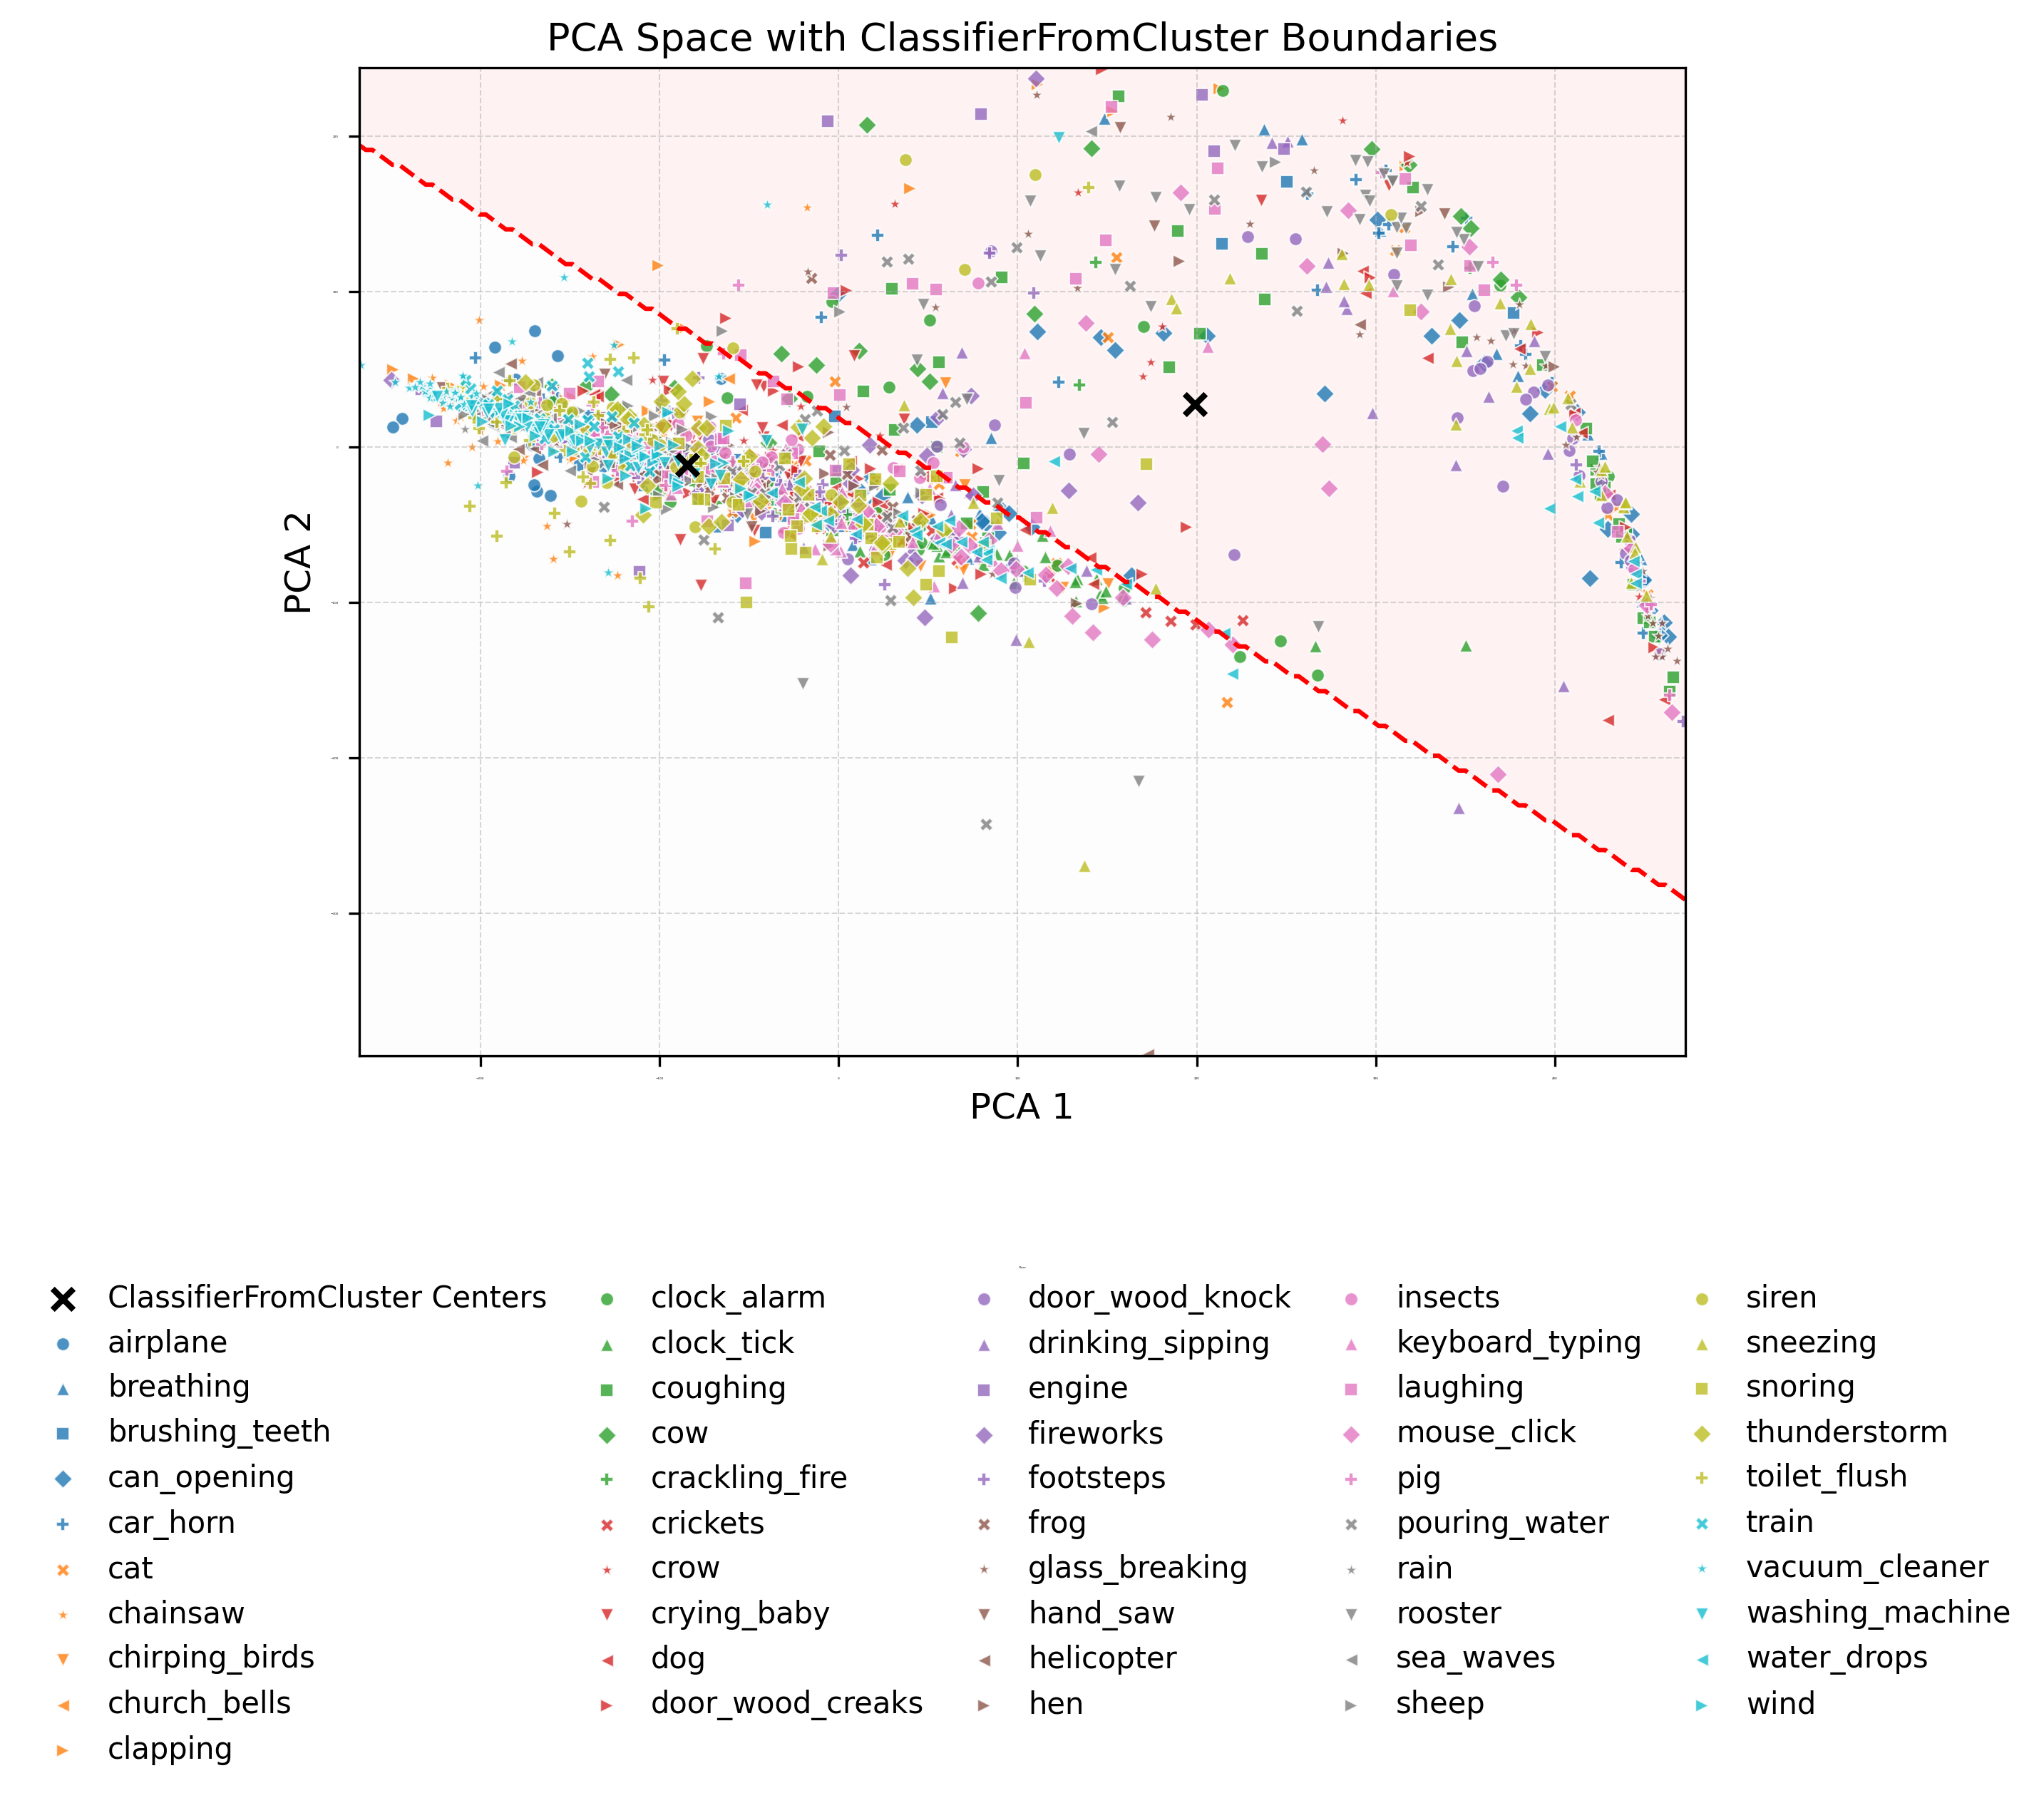

In [12]:
_ = clustering(
    projector,
    classifier, 
    X, 
    y
)

In [13]:
@torch.no_grad()
def audio_pipeline(audio_tensor:torch.Tensor):
    audio_tensor = audio_tensor.to(device)
    latent = to_latent(audio_tensor).view(1, 300).detach().cpu().numpy()
    latent = projector.transform(latent)
    label = classifier.predict(latent)
    return label

In [27]:
# infer_all()

In [31]:
pca_cluster_csv = pd.read_csv("pca_clustering_results.csv")

In [48]:
from IPython.display import Audio, display

In [62]:
from IPython.display import Audio, display
def n_audio(cls_name, csv:pd.DataFrame, n=5):
    cls =  csv[pca_cluster_csv["original_label"] == cls_name]
    for i in range(5):
        display(Audio(airplanes['path'].values[i]))

In [63]:
n_audio("train", pca_cluster_csv)

In [64]:
n_audio("airplane", pca_cluster_csv)

In [ ]:
to_